## GEORGIOS KOUTROUMPIS, AEM 9668
### ECE AUTh, 2022
### Computational Intelligence
#### Project 4, RBF

In [ ]:
%pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 37.1 MB/s 
     |████████████████████████████████| 1.6 MB 56.4 MB/s 


In [ ]:
# Imports
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.datasets import boston_housing
from keras import layers
from keras.layers import Layer
from keras.initializers import Initializer, Constant
from sklearn.cluster import KMeans
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt

In [ ]:
# Define custom RBF layer
class RBFLayer(Layer): 

  # Initialization
  def __init__(self, output_dim, initializer, betas=1.0, **kwargs):    
    self.output_dim = output_dim 
    self.betas = 1.0
    self.initializer = initializer
    super(RBFLayer, self).__init__(**kwargs)

  def build(self, input_shape): 
    self.c = self.add_weight(name = 'c', 
      shape=(self.output_dim, input_shape[1]), 
      initializer = self.initializer, trainable = False) 

    d_max = 0
    for i in range(0, self.output_dim):
      for j in range(0, self.output_dim):
          d = np.linalg.norm(self.c[i] - self.c[j])
          if d > d_max:
              d_max = d

    sigma = d_max / np.sqrt(2 * self.output_dim)
    self.b = np.ones(self.output_dim) / (2 * (sigma ** 2))

    super(RBFLayer, self).build(input_shape)

  def call(self, input_data): 
    C = K.expand_dims(self.c)
    H = K.transpose(C-K.transpose(input_data))
    return K.exp(-self.b * K.sum(H**2, axis=1))

  def compute_output_shape(self, input_shape):
      return (input_shape[0], self.output_dim)

class InitCentersKMeans(Initializer):
    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter
        super().__init__()

    def __call__(self, shape, dtype=None, *args):
        assert shape[1] == self.X.shape[1]
        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_


In [ ]:
(X_train, Y_train), (X_test, Y_test) = boston_housing.load_data(test_split=0.25)

# Normalize data
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

65536/57026 [==================================] - 0s 0us/step


In [ ]:
def Rsquare(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred ))
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )


def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

def plot_metrics(history):
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for Rsquare
  plt.plot(history.history['Rsquare'])
  plt.plot(history.history['val_Rsquare'])
  plt.title('model Rsquare error')
  plt.ylabel('Rsquare')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for rmse
  plt.plot(history.history['rmse'])
  plt.plot(history.history['val_rmse'])
  plt.title('model rmse')
  plt.ylabel('rmse')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def build_RBF_model(hp):

  model = Sequential()

  input_shape = (13,)
  train_data = X_train.shape[0]

  rbf_neurons_vals = [int(0.05*train_data),int(0.15*train_data),
                      int(0.3*train_data),int(0.5*train_data)]

  hp_rbf_neurons = hp.Choice('rbf_neurons', values=rbf_neurons_vals)
  hp_units_layer_2 = hp.Choice('units', values=[32, 64, 128, 256])
  hp_dropout = hp.Choice('dropout', values=[0.2, 0.35, 0.5])

  model.add(RBFLayer(hp_rbf_neurons, initializer=InitCentersKMeans(X_train), 
                      input_shape=input_shape))
  model.add(Dense(hp_units_layer_2))
  model.add(Dropout(hp_dropout))
  model.add(Dense(1))

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), 
                loss=mse, 
                metrics=[Rsquare,
                         tf.keras.metrics.RootMeanSquaredError("rmse")])
  return model

In [ ]:
# Find optimal hyper-parameters using Keras Tuner and Hyperband
epochs = 100

tuner = kt.Hyperband(build_RBF_model,
                     objective=kt.Objective("val_rmse", direction="min"),
                     max_epochs=epochs,
                     factor=3,
                     overwrite=True)


tuner.search(X_train, Y_train, epochs=epochs, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of neurons in the RBF
layer is {best_hps.get('rbf_neurons')}, in the second layer is {best_hps.get('units')}, the optimal 
dropout probability is {best_hps.get('dropout')}.
""")


Trial 47 Complete [00h 00m 27s]
val_rmse: 24.771787643432617

Best val_rmse So Far: 22.182859420776367
Total elapsed time: 00h 07m 58s

The hyperparameter search is complete. The optimal number of neurons in the RBF
layer is 18, in the second layer is 32, the optimal 
dropout probability is 0.35.



In [ ]:
# Train optimal model
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(X_train, Y_train, epochs=epochs, validation_split=0.2)

Epoch 1/100
10/10 [==============================] - 0s 19ms/step - loss: 508.6949 - Rsquare: -6.3329 - rmse: 22.5543 - val_loss: 664.6041 - val_Rsquare: -6.7159 - val_rmse: 25.7799
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 418.9517 - Rsquare: -4.8906 - rmse: 20.4683 - val_loss: 534.7047 - val_Rsquare: -4.9678 - val_rmse: 23.1237
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 296.3389 - Rsquare: -2.9460 - rmse: 17.2145 - val_loss: 372.9229 - val_Rsquare: -2.8319 - val_rmse: 19.3112
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 182.0024 - Rsquare: -1.4518 - rmse: 13.4908 - val_loss: 248.7712 - val_Rsquare: -1.2590 - val_rmse: 15.7725
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 116.6980 - Rsquare: -0.5230 - rmse: 10.8027 - val_loss: 190.3728 - val_Rsquare: -0.5797 - val_rmse: 13.7976
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 96.6193 - Rsquare: -0

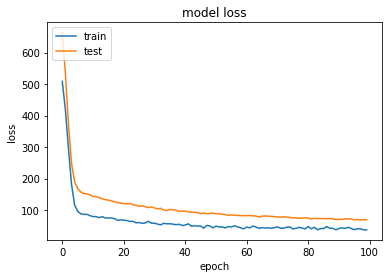

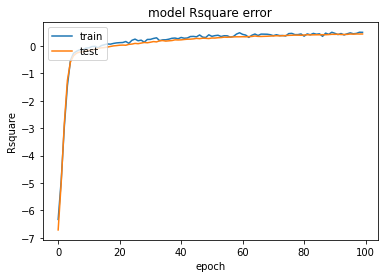

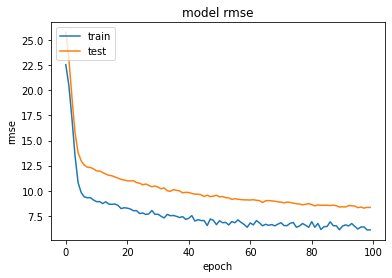

4/4 [==============================] - 0s 3ms/step - loss: 33.4709 - Rsquare: 0.5524 - rmse: 5.7854

Results on test data, using optimal hyperparameters

MSE     : 33.470882415771484

R^2     : 0.5523514747619629

RMSE    : 5.785402774810791



In [ ]:
# Plot metrics and scores on the test dataset for the final model
plot_metrics(history)

results = hypermodel.evaluate(X_test, Y_test)

print(f"""
Results on test data, using optimal hyperparameters\n
MSE     : {results[0]}\n
R^2     : {results[1]}\n
RMSE    : {results[2]}
""")